# Projet IA - HumanForYou
## Préparation et analyse des données
Ce notebook contient la préparation des données, l’analyse exploratoire (EDA) et la modélisation pour prédire l’attrition des employés.


## 1. Importation des librairies
Dans cette étape, nous importons toutes les librairies nécessaires pour :
- manipuler les données (pandas, numpy)
- faire des visualisations (matplotlib, seaborn)
- préparer et entraîner les modèles de Machine Learning (scikit-learn)


In [43]:
# =========================================================
# 1. Importation des librairies
# =========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Modèles ML
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

sns.set(style="whitegrid")


## 2. Chargement des données
Nous chargeons ici les différents fichiers CSV fournis :
- general_data : informations RH générales
- manager_survey_data : évaluations des managers
- employee_survey_data : satisfaction des employés
- in_time / out_time : heures d'arrivée et de départ (traité plus tard)

L’objectif est d’assembler l’ensemble des informations relatives à chaque employé.


In [44]:
general = pd.read_csv("data/general_data(1).csv")
manager = pd.read_csv("data/manager_survey_data.csv")
employee = pd.read_csv("data/employee_survey_data.csv")


Merge the datasets

In [45]:
df = general.merge(manager, on="EmployeeID", how="left")
df = df.merge(employee, on="EmployeeID", how="left")

df.head()


,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1.0,6,1,0,0,3,3,3.0,4.0,2.0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,6.0,3,5,1,4,2,4,3.0,2.0,4.0
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,5.0,2,5,0,3,3,3,2.0,2.0,1.0
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,13.0,5,8,7,5,2,3,4.0,4.0,3.0
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,9.0,2,6,0,4,3,3,4.0,1.0,3.0


Inspect before cleaning

In [46]:
df.shape
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1.0,6,1,0,0,3,3,3.0,4.0,2.0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,6.0,3,5,1,4,2,4,3.0,2.0,4.0
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,5.0,2,5,0,3,3,3,2.0,2.0,1.0
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,13.0,5,8,7,5,2,3,4.0,4.0,3.0
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,9.0,2,6,0,4,3,3,4.0,1.0,3.0


Identify numeric and categorical columns

In [47]:
num_cols = df.select_dtypes(include=['int64','float64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

num_cols, cat_cols


(Index(['Age', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeID',
        'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike',
        'StandardHours', 'StockOptionLevel', 'TotalWorkingYears',
        'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion',
        'YearsWithCurrManager', 'JobInvolvement', 'PerformanceRating',
        'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance'],
       dtype='object'),
 Index(['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender',
        'JobRole', 'MaritalStatus', 'Over18'],
       dtype='object'))

Fill missing values properly

A) Numeric columns → median

In [48]:
df[num_cols] = df[num_cols].fillna(df[num_cols].median())


Categorical columns → mode

In [49]:
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])


###Drop useless columns

These 3 columns have NO VARIATION → useless for ML:

EmployeeCount (always 1)

StandardHours (always 8)

Over18 (always “Y”)

In [50]:
df = df.drop(["EmployeeCount", "StandardHours", "Over18"], axis=1)


Convert Attrition to numeric (0/1)

In [51]:
df["Attrition"] = df["Attrition"].map({"Yes": 1, "No": 0})
df["Attrition"] = df["Attrition"].astype(int)


Final cleaning verification

In [52]:
print(df.isna().sum())      # MUST be all zeros
print(df.info())            # Attrition must be int64, useless columns removed
df.head()


Age                        0
Attrition                  0
BusinessTravel             0
Department                 0
DistanceFromHome           0
Education                  0
EducationField             0
EmployeeID                 0
Gender                     0
JobLevel                   0
JobRole                    0
MaritalStatus              0
MonthlyIncome              0
NumCompaniesWorked         0
PercentSalaryHike          0
StockOptionLevel           0
TotalWorkingYears          0
TrainingTimesLastYear      0
YearsAtCompany             0
YearsSinceLastPromotion    0
YearsWithCurrManager       0
JobInvolvement             0
PerformanceRating          0
EnvironmentSatisfaction    0
JobSatisfaction            0
WorkLifeBalance            0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age          

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,Gender,JobLevel,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,51,0,Travel_Rarely,Sales,6,2,Life Sciences,1,Female,1,...,1.0,6,1,0,0,3,3,3.0,4.0,2.0
1,31,1,Travel_Frequently,Research & Development,10,1,Life Sciences,2,Female,1,...,6.0,3,5,1,4,2,4,3.0,2.0,4.0
2,32,0,Travel_Frequently,Research & Development,17,4,Other,3,Male,4,...,5.0,2,5,0,3,3,3,2.0,2.0,1.0
3,38,0,Non-Travel,Research & Development,2,5,Life Sciences,4,Male,3,...,13.0,5,8,7,5,2,3,4.0,4.0,3.0
4,32,0,Travel_Rarely,Research & Development,10,1,Medical,5,Male,1,...,9.0,2,6,0,4,3,3,4.0,1.0,3.0


## 3. Saving the Cleaned Dataset
After cleaning the dataset, we save it as a new CSV file so we can reuse it later without repeating all preprocessing steps. This ensures reproducibility and protects our work.


In [53]:
os.makedirs("clean_data", exist_ok=True)

df.to_csv("clean_data/clean_data.csv", index=False)

print("Cleaned dataset saved successfully as clean_data/clean_data.csv")

Cleaned dataset saved successfully as clean_data/clean_data.csv


## 4. Loading the Cleaned Dataset (Optional)
If we want to reuse the cleaned dataset later, we can load it directly without repeating the cleaning process.


In [54]:
df = pd.read_csv("clean_data/clean_data.csv")
df.head()


,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,Gender,JobLevel,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,51,0,Travel_Rarely,Sales,6,2,Life Sciences,1,Female,1,...,1.0,6,1,0,0,3,3,3.0,4.0,2.0
1,31,1,Travel_Frequently,Research & Development,10,1,Life Sciences,2,Female,1,...,6.0,3,5,1,4,2,4,3.0,2.0,4.0
2,32,0,Travel_Frequently,Research & Development,17,4,Other,3,Male,4,...,5.0,2,5,0,3,3,3,2.0,2.0,1.0
3,38,0,Non-Travel,Research & Development,2,5,Life Sciences,4,Male,3,...,13.0,5,8,7,5,2,3,4.0,4.0,3.0
4,32,0,Travel_Rarely,Research & Development,10,1,Medical,5,Male,1,...,9.0,2,6,0,4,3,3,4.0,1.0,3.0


# 3. Exploratory Data Analysis (EDA)
In this section, we visualize the main features of the dataset to understand the distribution of variables and detect patterns related to employee attrition.


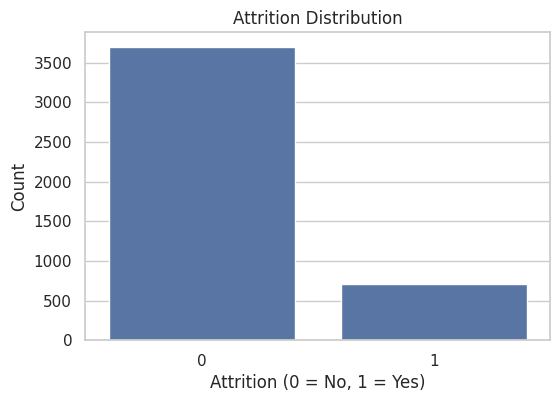

In [55]:
plt.figure(figsize=(6,4))
sns.countplot(x=df["Attrition"])
plt.title("Attrition Distribution")
plt.xlabel("Attrition (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()


Most employees did not leave the company (Attrition = 0).  
This means the dataset is imbalanced, which will affect machine learning performance.


Cleaned dataset saved successfully as clean_data.csv


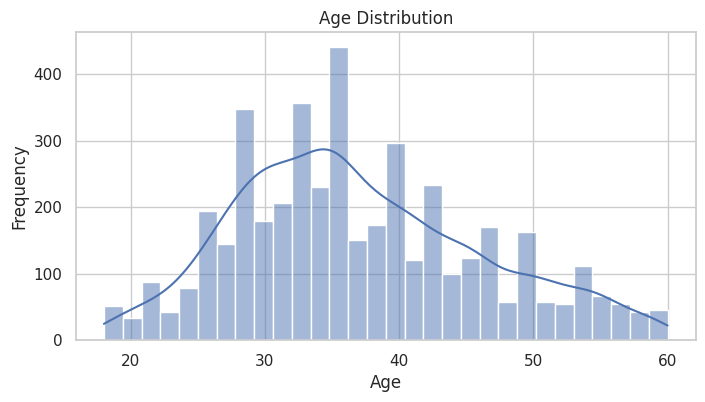

In [56]:
plt.figure(figsize=(8,4))
df.to_csv("clean_data/clean_data.csv", index=False)

print("Cleaned dataset saved successfully as clean_data.csv")

sns.histplot(df["Age"], kde=True, bins=30)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()


The age distribution is concentrated between 30 and 40 years old.  
Understanding age distribution helps detect patterns related to attrition risk.


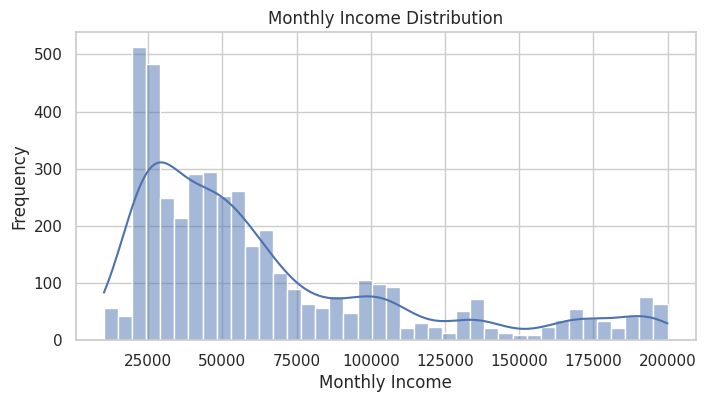

In [57]:
plt.figure(figsize=(8,4))
sns.histplot(df["MonthlyIncome"], kde=True, bins=40)
plt.title("Monthly Income Distribution")
plt.xlabel("Monthly Income")
plt.ylabel("Frequency")
plt.show()


Income is right-skewed, meaning most employees earn on the lower-middle range.  
This can help analyze if salary impacts attrition.


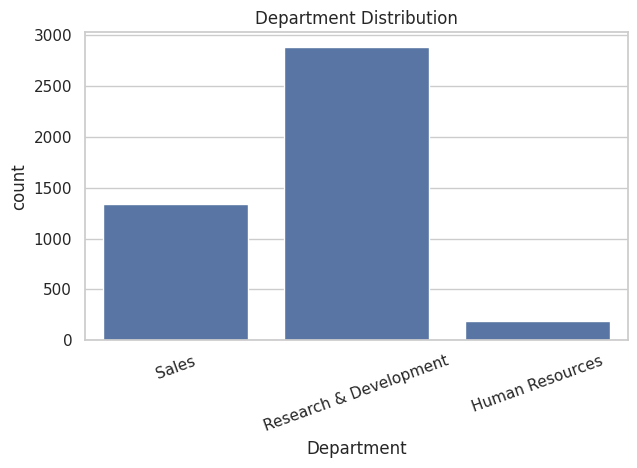

In [58]:
plt.figure(figsize=(7,4))
sns.countplot(x=df["Department"])
plt.title("Department Distribution")
plt.xticks(rotation=20)
plt.show()


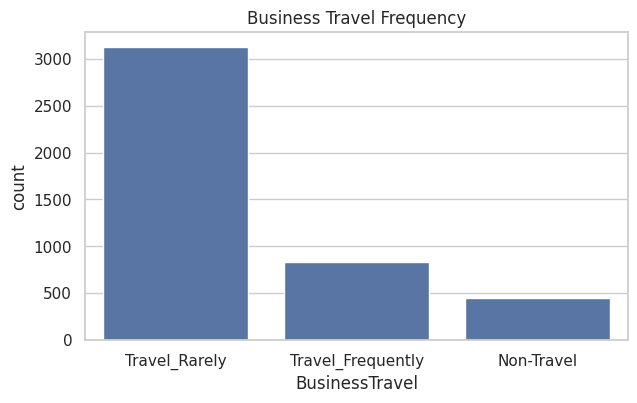

In [59]:
plt.figure(figsize=(7,4))
sns.countplot(x=df["BusinessTravel"])
plt.title("Business Travel Frequency")
plt.show()


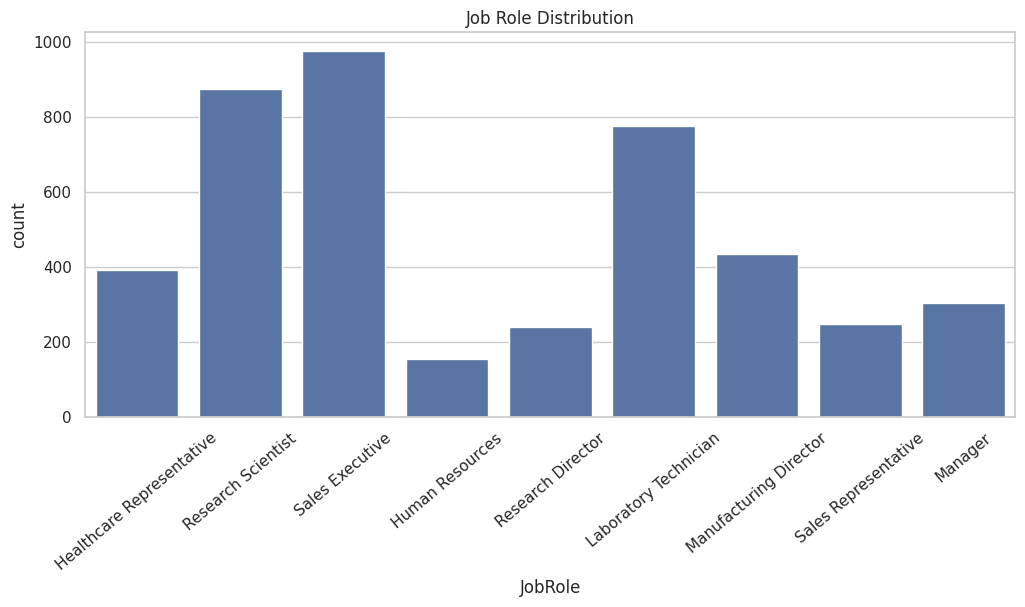

In [60]:
plt.figure(figsize=(12,5))
sns.countplot(x=df["JobRole"])
plt.title("Job Role Distribution")
plt.xticks(rotation=40)
plt.show()


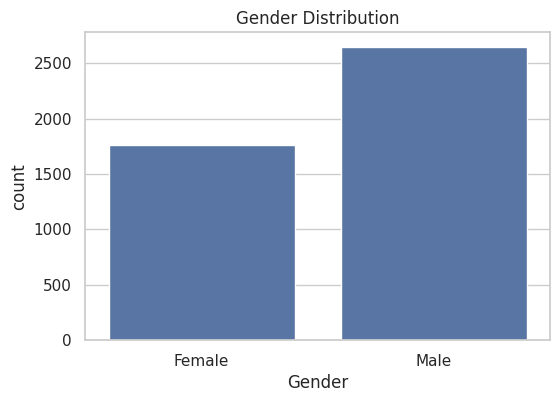

In [61]:
plt.figure(figsize=(6,4))
sns.countplot(x=df["Gender"])
plt.title("Gender Distribution")
plt.show()


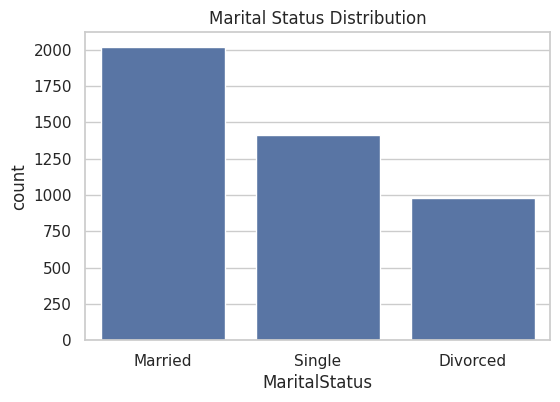

In [62]:
plt.figure(figsize=(6,4))
sns.countplot(x=df["MaritalStatus"])
plt.title("Marital Status Distribution")
plt.show()


Categorical variable distributions show how employees are spread across roles, departments, gender, and travel frequency.  
These graphs help identify potential factors contributing to attrition.


#Correlation Heatmap

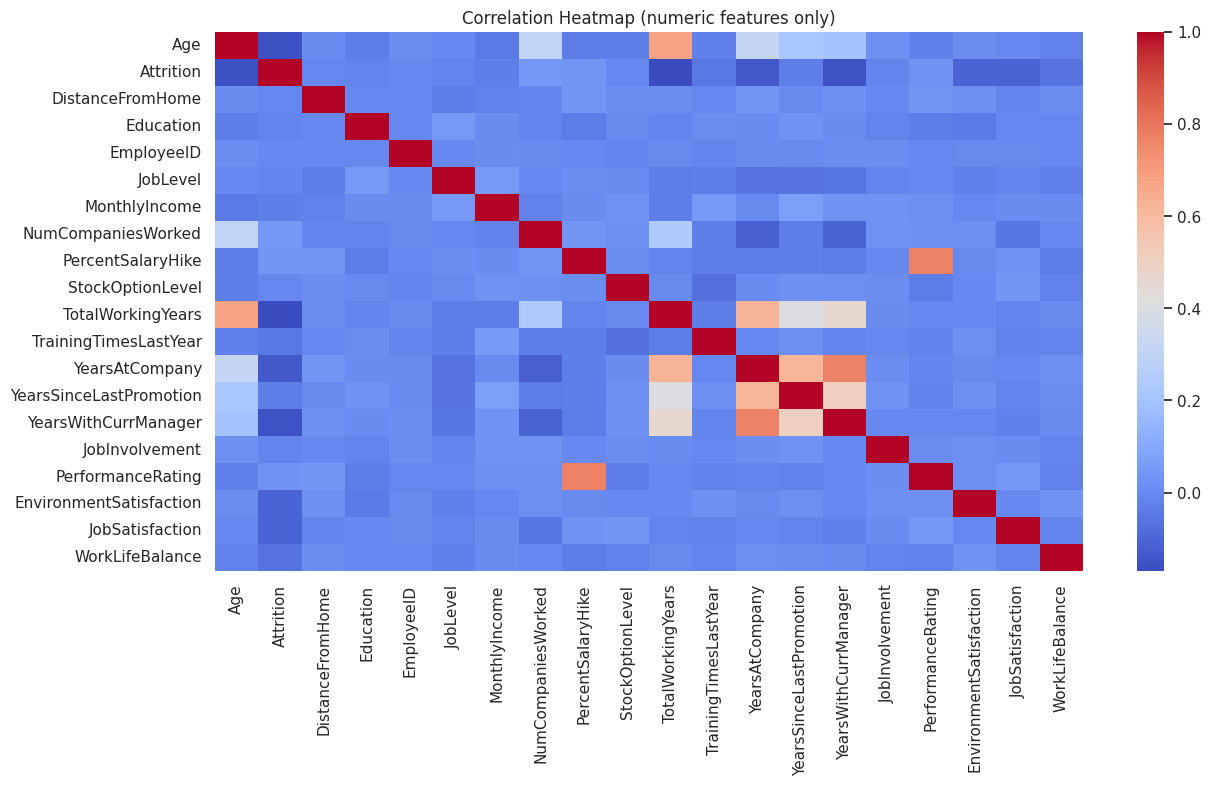

In [63]:
# ...existing code...
plt.figure(figsize=(14,7))
# option A: select numeric columns explicitly
corr = df.select_dtypes(include=[np.number]).corr()
# alternatively: corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap (numeric features only)")
plt.show()
# ...existing code...

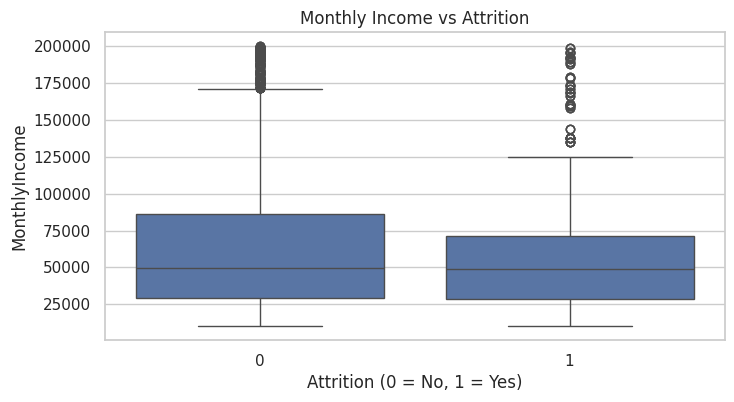

In [64]:
plt.figure(figsize=(8,4))
sns.boxplot(x=df["Attrition"], y=df["MonthlyIncome"])
plt.title("Monthly Income vs Attrition")
plt.xlabel("Attrition (0 = No, 1 = Yes)")
plt.show()


Employees who left the company (Attrition = 1) may show different income distributions.  
Boxplots help detect patterns such as low salary → higher attrition.


Boxplot: YearsAtCompany vs Attrition

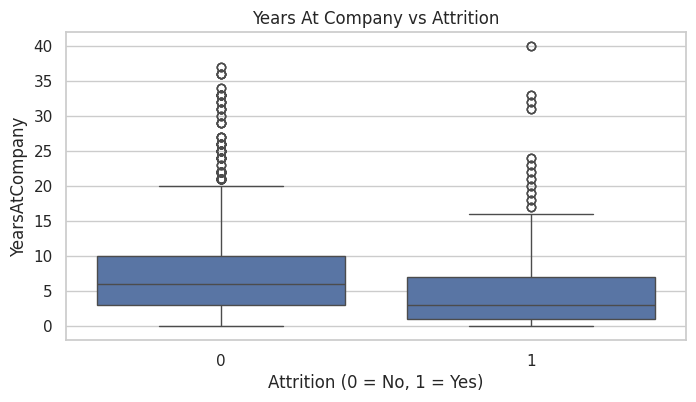

In [65]:
plt.figure(figsize=(8,4))
sns.boxplot(x=df["Attrition"], y=df["YearsAtCompany"])
plt.title("Years At Company vs Attrition")
plt.xlabel("Attrition (0 = No, 1 = Yes)")
plt.show()


Employees with fewer years at the company tend to be more likely to leave early.  
This is a typical HR pattern, showing early turnover risk.


# 6 2️⃣ Prepare the data for Machine Learning

Split X and y

In [66]:
X = df.drop("Attrition", axis=1)
y = df["Attrition"]


Train-test split

In [67]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

now i will create the preprocessing pipeline : cuzz our dataframe has numeric columns (age , income ...) and categorical columne (gender ...)
the solution for this is ti use :

OneHotEncoder() → converts categories to numbers

StandardScaler() → normalizes numeric values

Identify numeric + categorical columns

In [68]:
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns


Create the preprocessing pipeline

In [69]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

preprocess = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown='ignore'), cat_cols)
])


normaly after this preprocessing pipeline we can CHOOSE ML ALGORITHMS

In [70]:
print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

Numeric columns: Index(['Age', 'DistanceFromHome', 'Education', 'EmployeeID', 'JobLevel',
       'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction',
       'JobSatisfaction', 'WorkLifeBalance'],
      dtype='object')
Categorical columns: Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus'],
      dtype='object')


that's mean that our preprocessing pipeline work ! it can classify collumns !!!

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

model = Pipeline([
    ("preprocess", preprocess),
    ("clf", LogisticRegression(max_iter=1000))
])

model.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [72]:
y_pred = model.predict(X_test)
print(y_pred[:10])

[0 0 0 1 0 0 0 1 0 0]


now we just completed:

✔ Data Cleaning



✔ Data Preparation


✔ EDA (Graphs)




✔ Train/Test Split




✔ Preprocessing Pipeline (StandardScaler + OneHotEncoder)




✔ Verification of transformation

 This means your dataset is 100% ML-ready.